In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import datetime as dt
import pandas_datareader.data as web
import os
import warnings

# print all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

C:\Users\Dr Msakni\AppData\Roaming\Python\Python39\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# downloading historical necessary data for backtesting and analysis
_start = dt.date(2015,1,2)
_end = dt.date(2020,4,30)
ticker = 'GOOG'
df = yf.download(ticker, start = _start, end = _end)

[*********************100%***********************]  1 of 1 completed


In [3]:
# calculating buy and hold strategy returns
df['bnh_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df.head(5)

,Open,High,Low,Close,Adj Close,Volume,bnh_returns
Date,,,,,,,
2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268,NaN
2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796,-0.021066
2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800,-0.023450
2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082,-0.001715
2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641,0.003148


In [4]:
# creating bollinger band indicators
df['ma20'] = df['Adj Close'].rolling(window=20).mean()
df['std'] = df['Adj Close'].rolling(window=20).std()
df['upper_band'] = df['ma20'] + (2 * df['std'])
df['lower_band'] = df['ma20'] - (2 * df['std'])
df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
df.tail(5)

,Close,Adj Close,Volume,bnh_returns,ma20,std,upper_band,lower_band
Date,,,,,,,,
2020-04-23,63.815498,63.815498,31324000,0.010317,60.050100,3.126802,66.303704,53.796495
2020-04-24,63.965500,63.965500,32792000,0.002348,60.344000,3.207819,66.759638,53.928361
2020-04-27,63.793999,63.793999,32012000,-0.002685,60.756925,3.085472,66.927869,54.585980
2020-04-28,61.683498,61.683498,59026000,-0.033643,60.974050,2.983549,66.941148,55.006951
2020-04-29,67.073997,67.073997,75872000,0.083780,61.420724,3.198024,67.816772,55.024677


In [5]:

# BUY condition
df['signal'] = np.where((df['Adj Close'] < df['lower_band']) &
                        (df['Adj Close'].shift(1) >=       df['lower_band']),1,0)

# SELL condition
df['signal'] = np.where( (df['Adj Close'] > df['upper_band']) &
                          (df['Adj Close'].shift(1) <= df['upper_band']),-1,df['signal'])
# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])

df.tail(5)

,Close,Adj Close,Volume,bnh_returns,ma20,std,upper_band,lower_band,signal,position,strategy_returns
Date,,,,,,,,,,,
2020-04-23,63.815498,63.815498,31324000,0.010317,60.050100,3.126802,66.303704,53.796495,0,-1.0,-0.010317
2020-04-24,63.965500,63.965500,32792000,0.002348,60.344000,3.207819,66.759638,53.928361,0,-1.0,-0.002348
2020-04-27,63.793999,63.793999,32012000,-0.002685,60.756925,3.085472,66.927869,54.585980,0,-1.0,0.002685
2020-04-28,61.683498,61.683498,59026000,-0.033643,60.974050,2.983549,66.941148,55.006951,0,-1.0,0.033643
2020-04-29,67.073997,67.073997,75872000,0.083780,61.420724,3.198024,67.816772,55.024677,0,-1.0,-0.083780


Buy and hold returns: 0.9412341874860299
Strategy returns: 0.86032206769372


<AxesSubplot:xlabel='Date'>

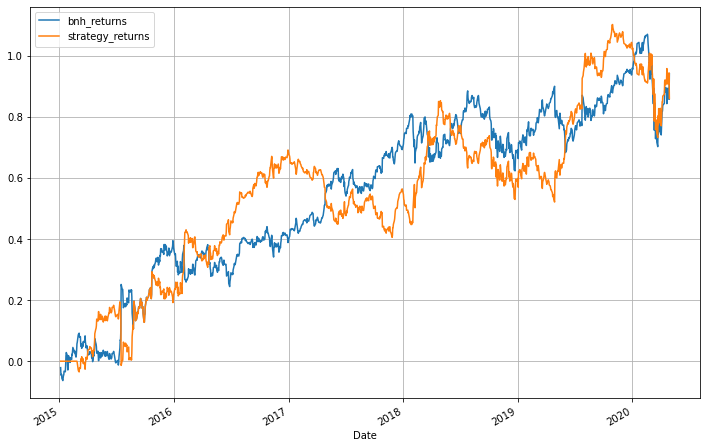

In [6]:
# comparing buy & hold strategy / bollinger bands strategy returns
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

C:\Users\Dr Msakni\AppData\Roaming\Python\Python39\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2015-01-02
End date,2020-04-29
Total months,63
,Backtest
Annual return,13.5%
Cumulative returns,96.1%
Annual volatility,26.4%
Sharpe ratio,0.61
Calmar ratio,0.41
Stability,0.74
Max drawdown,-33.2%


C:\Users\Dr Msakni\AppData\Roaming\Python\Python39\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


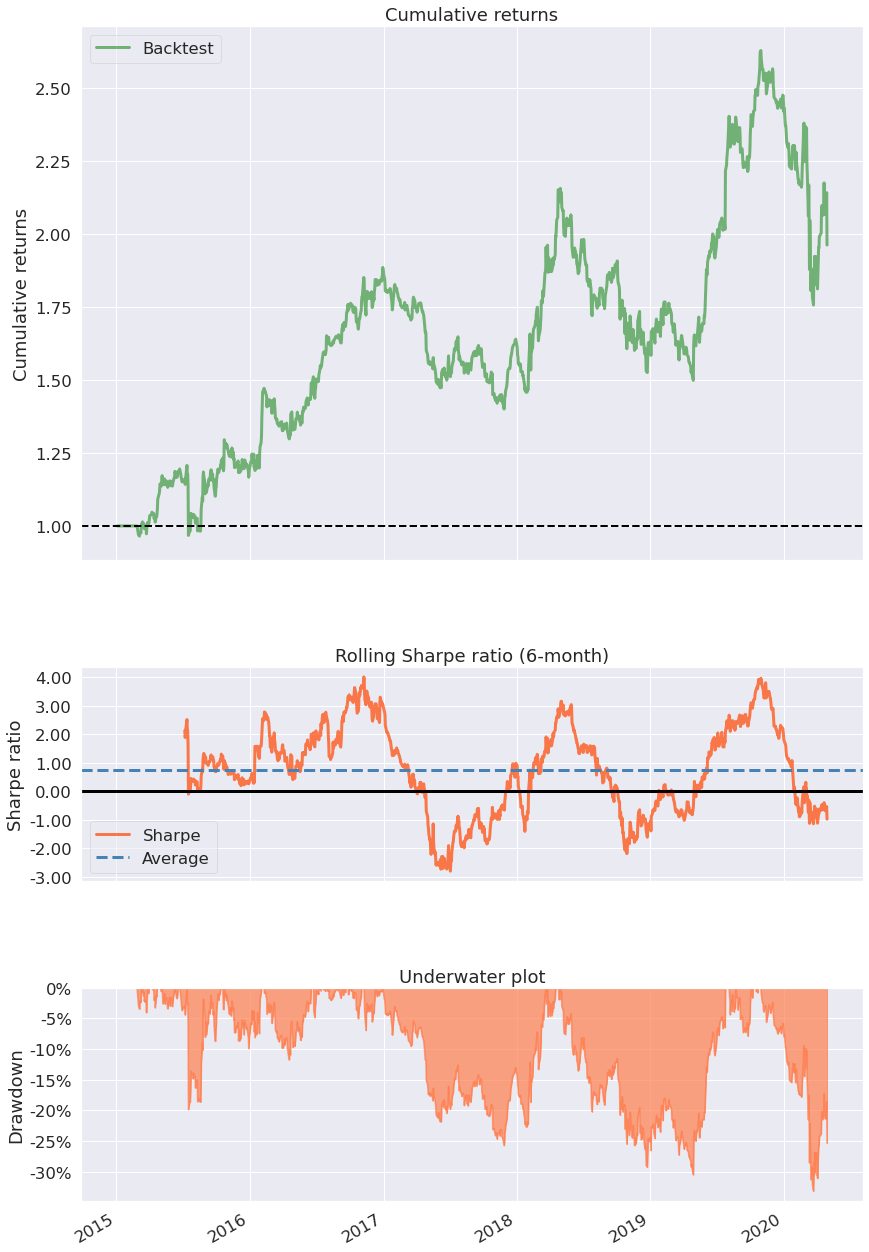

In [7]:
pf.create_simple_tear_sheet(df['strategy_returns'].diff())